<h2>
<center>Pairs Selection:</center>
<center>Applying PCA and OPTICS clustering to stock prices</center>
</h2>



## Introduction
Pairs trading is a strategy used by many financial institutions. Within this strategy, fund managers attempt to construct a mean-reverting prices series of pairs of securities. As the prices series reverts to its long-term mean, the fund manager closes or opens positions accordingly to profit. As more financial securities are traded, the universe of potential pairs continues to balloon in size. This increase in size leads to more instances of spurious correlations among financial securities. To constrain the search universe and avoid spurious correlations, Sarmento and Horta outline an unsupervised clustering approach to find securities for pairs trading in their work: <a href="https://www.springer.com/gp/book/9783030472504#aboutBook"> “A Machine Learning based Pairs Trading Investment Strategy.”</a> [1].

## Body

### State 0: Data collection

Daily closing prices from S&P 500 listed publicly traded U.S. securities were sampled for this notebook. Data ranges from 2020-01-01 through 2021-12-31. Data from 2021-01-01 through 2022-12-31 is held out for testing.

In [113]:
import seaborn as sn
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

In [114]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))

In [115]:
len(df[0]['Symbol'])

503

In [116]:
from mlpairs import OpticsPairs

In [117]:
def get_historical_Data(tickers, startDate, endDate):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=startDate, end=endDate).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data



In [118]:
def get_dataset(df_name):
    ticker = yf.Ticker(df_name)
    df = ticker.history(start="2014-01-01", end="2024-03-15", period="1D")
    return df

In [119]:
ticks = df[0]['Symbol'] #Name of company (Dominos pizza)
d = get_historical_Data(ticks, "2014-01-01", "2024-03-15")
print(d.shape)
# Most Recent Data
d.tail()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

(2567, 503)


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-08 00:00:00,93.900002,85.820000,120.959999,178.850006,378.170013,551.690002,207.389999,16.250000,82.110001,147.869995,...,273.709991,970.320007,100.430000,50.477108,127.080002,139.559998,282.589996,126.739998,42.240002,182.160004
2024-03-11 00:00:00,94.050003,85.309998,120.190002,179.630005,373.220001,560.419983,198.389999,16.389999,83.169998,147.289993,...,271.970001,963.989990,103.230003,52.346996,126.180000,140.080002,280.230011,128.039993,41.610001,183.490005
2024-03-12 00:00:00,98.720001,85.930000,120.760002,180.919998,380.480011,579.140015,202.759995,15.940000,82.940002,147.839996,...,274.980011,972.429993,103.040001,51.347744,128.460007,140.740005,285.440002,128.210007,40.900002,181.350006
2024-03-13 00:00:00,104.070000,86.160004,120.160004,179.860001,378.720001,573.549988,194.789993,15.750000,83.800003,147.820007,...,274.899994,974.739990,102.330002,50.952000,128.020004,138.360001,284.500000,126.589996,41.070000,176.229996
2024-03-14 00:00:00,103.120003,86.620003,118.849998,181.199997,378.209991,570.450012,187.059998,15.030000,83.570000,145.210007,...,274.000000,991.690002,101.000000,51.880001,127.959999,137.160004,281.769989,125.730003,39.799999,173.880005


In [120]:
train = pd.DataFrame(d)


In [121]:
# cleaning the data. Data has Nan values for some stocks.

train.dropna(inplace=True, axis=1)
missing_values = train.isnull()

# Step 3: Optionally, check if there are any missing values in the DataFrame
if missing_values.any().any():
    print("There are missing values in the DataFrame.")
else:
    print("There are no missing values in the DataFrame.")

There are no missing values in the DataFrame.


### State 1: Dimensionality Reduction  
### Calculate return series

In [122]:
op = OpticsPairs(train)
op.returns.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03 00:00:00,0.002317,-0.000187,0.010725,0.006156,0.003328,-0.002193,0.012658,-0.004905,0.002881,0.012632,...,-0.009054,-0.000870,-0.009801,-0.000364,0.009075,0.006259,0.007522,0.004336,0.007083,-0.009580
2014-01-06 00:00:00,-0.005923,-0.000750,0.013199,-0.036520,-0.010565,-0.017579,0.032500,0.009859,-0.019199,-0.004919,...,0.000229,-0.007396,-0.000714,-0.005454,-0.001741,-0.000794,-0.003359,0.006477,-0.007033,-0.002184
2014-01-07 00:00:00,0.000145,-0.009761,-0.007663,0.001984,0.012167,0.014625,0.012106,0.017434,0.003237,0.014301,...,0.002969,0.007770,0.028847,0.017184,0.002906,0.014040,0.010300,0.019948,0.003036,0.003752
2014-01-08 00:00:00,-0.007410,-0.011375,0.009009,-0.002575,0.007728,-0.001187,0.000000,-0.019877,-0.007067,0.016362,...,0.001594,0.002056,0.018759,-0.003954,-0.000579,-0.000392,-0.000741,0.024501,0.008742,-0.011215
2014-01-09 00:00:00,-0.001317,0.006328,0.001785,0.017077,0.009739,0.003226,-0.021531,0.011189,-0.005570,0.000342,...,0.007047,0.004183,-0.002533,0.003969,0.004059,-0.019339,0.004637,-0.009854,0.007333,0.006931


### Apply PCA

Principal component analysis is applied to the scaled return series. The below graphs plot the loadings on of each security on the first five principal components. It is unsurprising that nearly every security has a similar loading on the first principal component. This component is generally interpreted as the “market” component of financial instruments which explains much of the variation in price movements across securities. Because our sample data consist of publicly traded U.S. equity listings, we expect to see the presence of this first principal component.

### Step 1: Standardize Data

<center> <font size="3"> $ z = \frac{x - \mu}{\sigma} $ </font> </center>

### Step 2: Compute Covariance Matrix

<center> <font size="3"> $ cov(X, Y) = \frac{1}{N-1}\displaystyle\sum_{i=1}^{N}(X_i-\bar{x})(Y_i-\bar{y}) $ </font> </center>

### Step 3: Compute Eigenvectors and Eigenvalues


<center> <font size='3'> $A\overrightarrow{v} = \lambda\overrightarrow{v}$ </font></center>
<center> <font size='3'> $ \overrightarrow{v}(A - \lambda I) = 0$ </font></center>
<center> <font size='3'> Where $A$ is the covariance matrix, $I$ is the identity matrix, $\overrightarrow{v}$ are eigenvectors, and $\lambda$ are eigenvalues. </font></center>


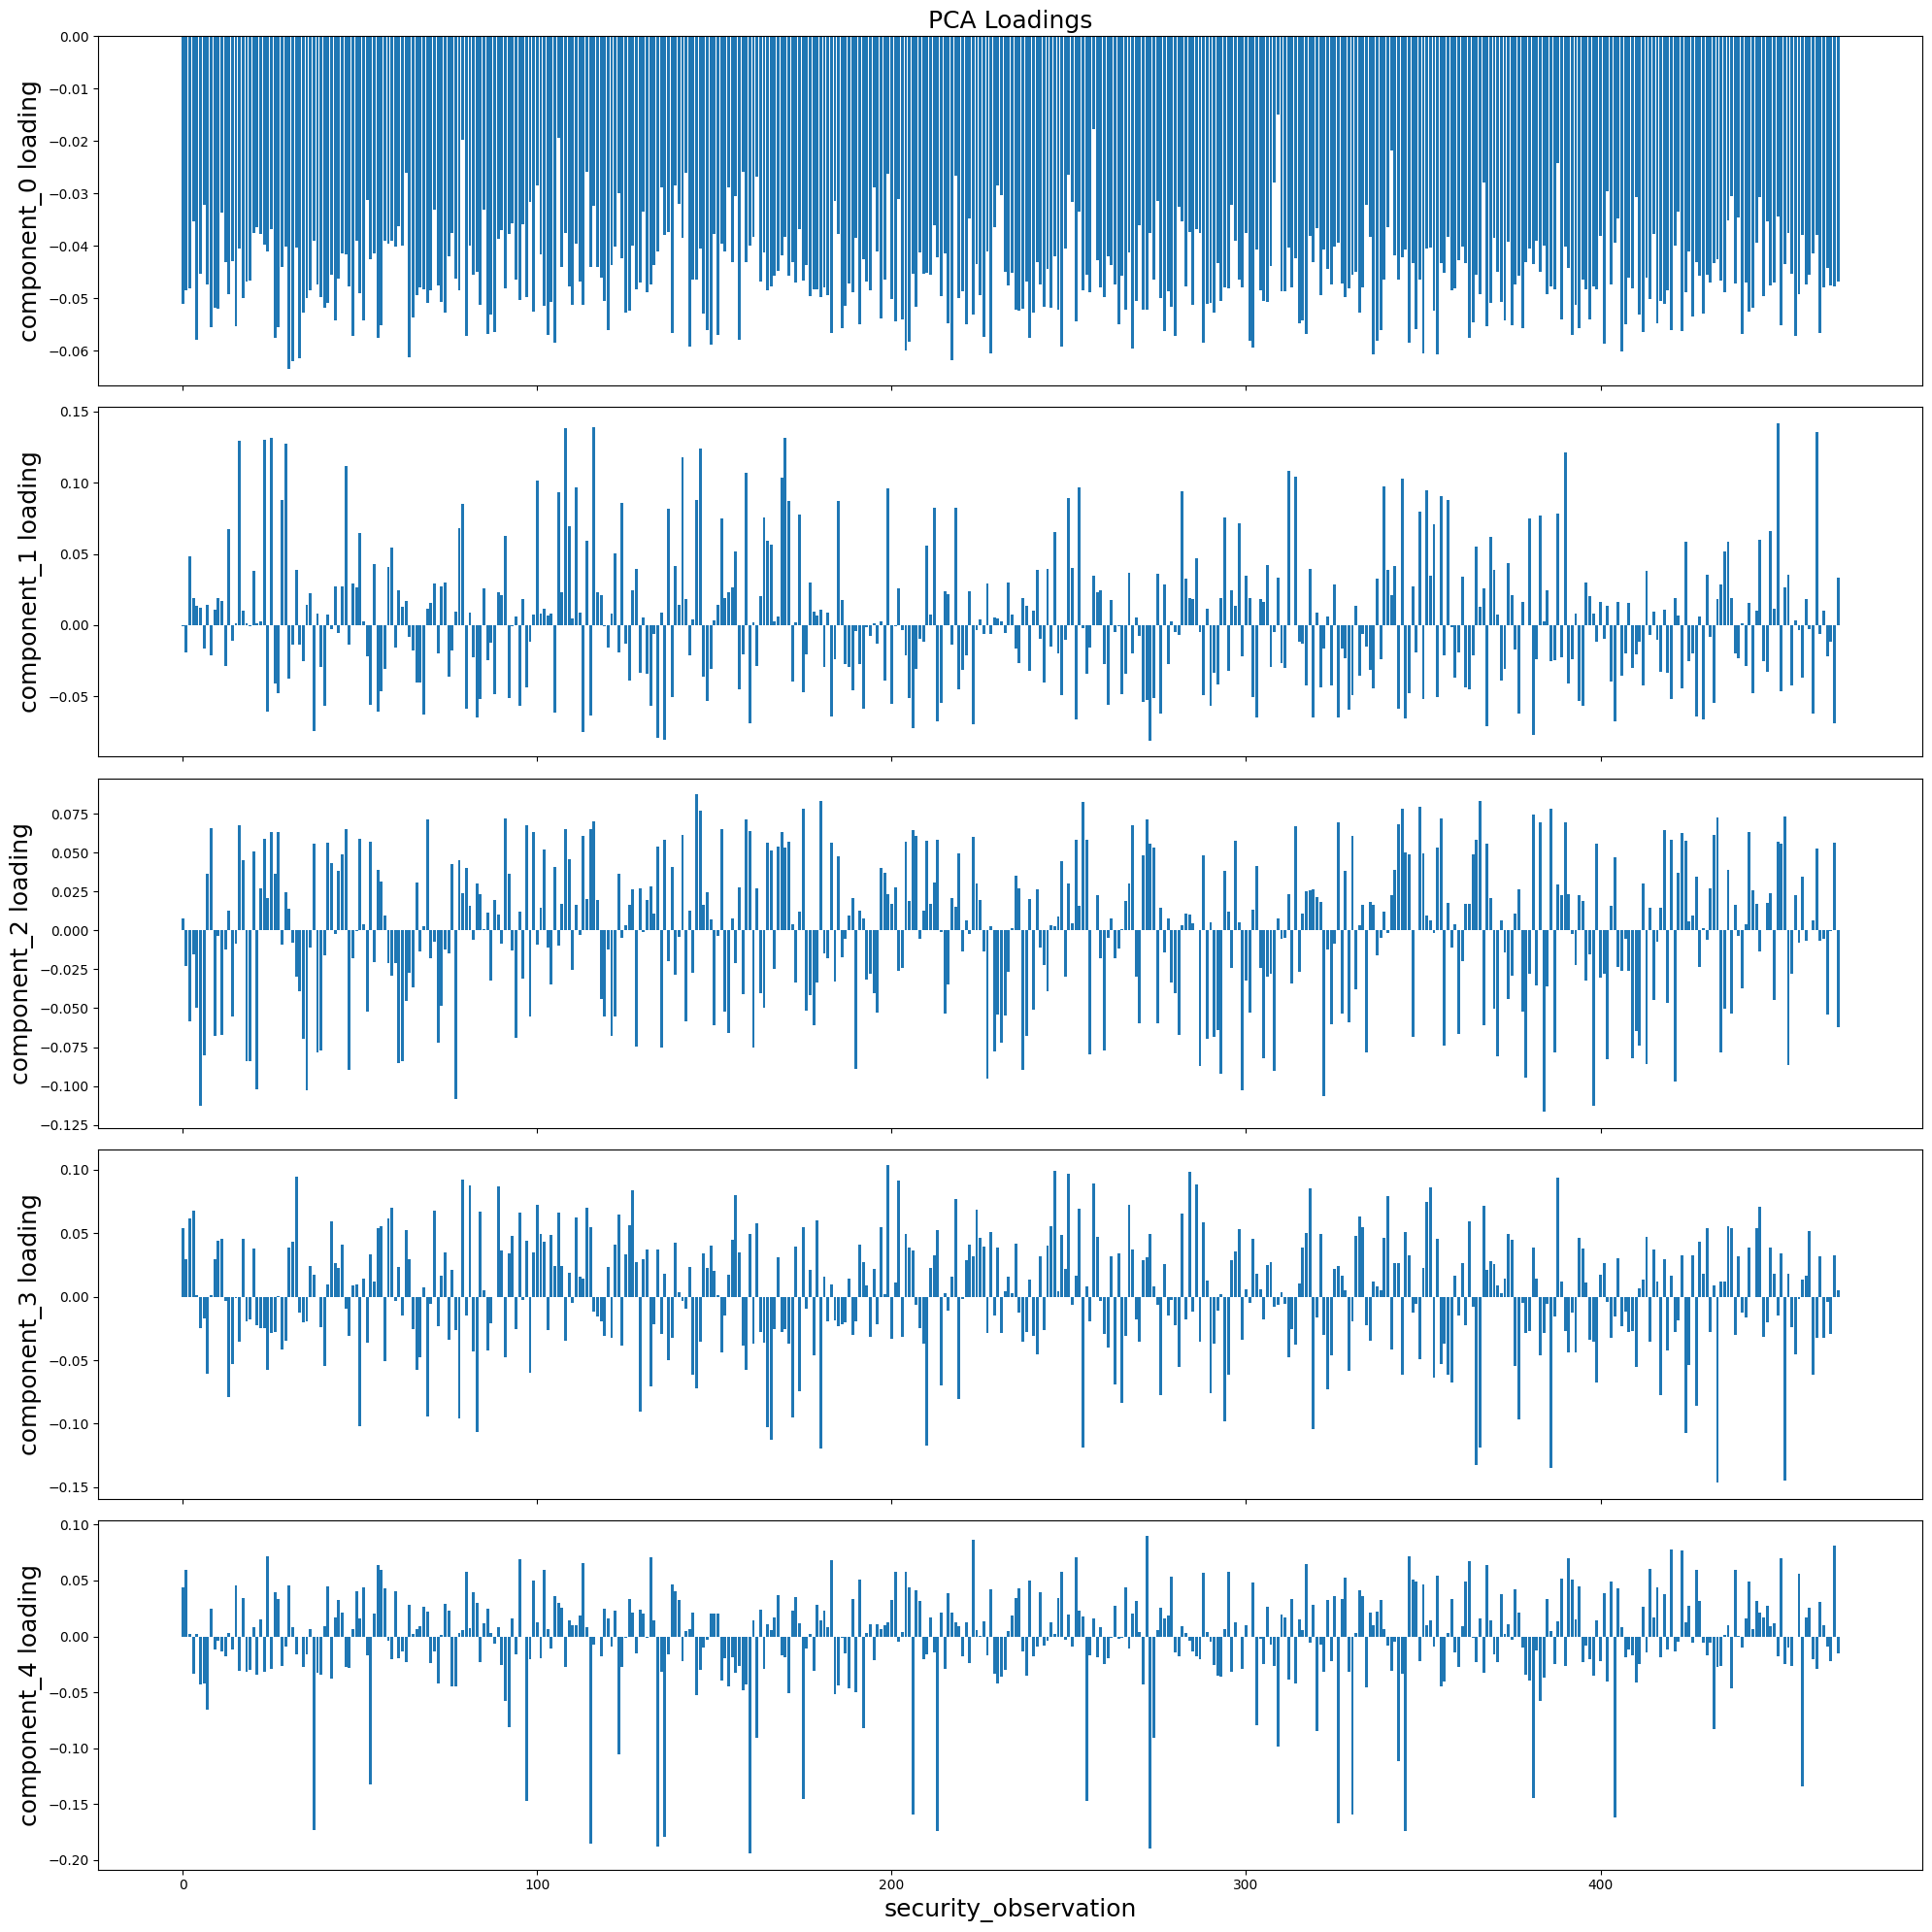

In [123]:
op.reduce_PCA()
op.plot_loadings()

Implementing PCA reduced the dimensions of our data. Below we chart the cumulative variance explained by the 10 dimensions in component space. Total variance explained: 68.0%


Total variance explained: 56.00000000000001%


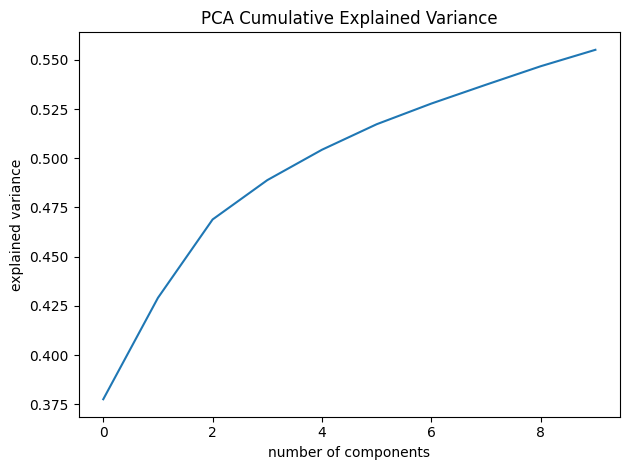

In [124]:
import numpy as np
op.plot_explained_variance()
total_variance_explained = np.cumsum(op.explained_variance_ratio_)[-1]
print(f"Total variance explained: {round(total_variance_explained, 2)*100}%")

## State 2: Unsupervised Learning
### Apply OPTICS


Unlike other clustering algorithms, OPTICS computes an augmented cluster-ordering of the data rather than clustering the data explicitly. This frees the algorithm from relying on global parameters that might be heavily influenced by one cluster, but not accurately describe other clusters. Ankerst et. al state, “It is a versatile basis for both automatic and interactive
cluster analysis” [2].

A point $p$ is considered a core point if at least $MinPts$ are found within its $\epsilon$-neighborhood. Each point is given a core-dist which denotes the distance to the nearest $MinPts$th closest point. The calculation for core-dist is described below:

<center> ${\displaystyle {\text{core-dist}}_{\mathit {\varepsilon ,MinPts}}(p)={\begin{cases}{\text{UNDEFINED}}&{\text{if }}|N_{\varepsilon }(p)|<{\mathit {MinPts}}\\{\mathit {MinPts}}{\text{-th smallest distance in }}N_{\varepsilon }(p)&{\text{otherwise}}\end{cases}}}$ </center>

The reachability-distance of another point $o$ from a point $p$ is either the distance between $o$ and $p$, or the core distance of $p$, whichever is bigger. The calculation for core-dist is described below:

<center> ${\displaystyle {\text{reachability-dist}}_{\mathit {\varepsilon ,MinPts}}(o,p)={\begin{cases}{\text{UNDEFINED}}&{\text{if }}|N_{\varepsilon }(p)|<{\mathit {MinPts}}\\\max({\text{core-dist}}_{\mathit {\varepsilon ,MinPts}}(p),{\text{dist}}(p,o))&{\text{otherwise}}\end{cases}}}$ </center>

If $p$ and $o$ are nearest neighbors, this is the ${\displaystyle \varepsilon '<\varepsilon }$ we need to assume to have $p$ and $o$ belong to the same cluster.

### Generate clusters and find potential trading pairs

The OPTICS algorithm identified 1277 potential pairs of securities that share a common label generated from unsupervised learning.


In [125]:
op.find_pairs()
op.pairs

Found 658 potential pairs


0        (CSX, DE)
1         (CSX, J)
2       (CSX, NSC)
3       (CSX, UNP)
4          (DE, J)
          ...     
653     (REG, VTR)
654    (REG, WELL)
655     (SPG, VTR)
656    (SPG, WELL)
657    (VTR, WELL)
Length: 658, dtype: object

To visually inspect the clusters, we plot the loadings of the first two and first three principal components from each security. We can clearly see one cluster of securities that stands out from the rest in the upper left of the 2-dimensional graph. Additionally, when adding a third principal component, we can more easily see other clusters group together along the z-axis.

The light points share a common label indicate data points considered noise and are excluded and the corresponding securities are excluded from the potential pairs list.


### Plot clusters found

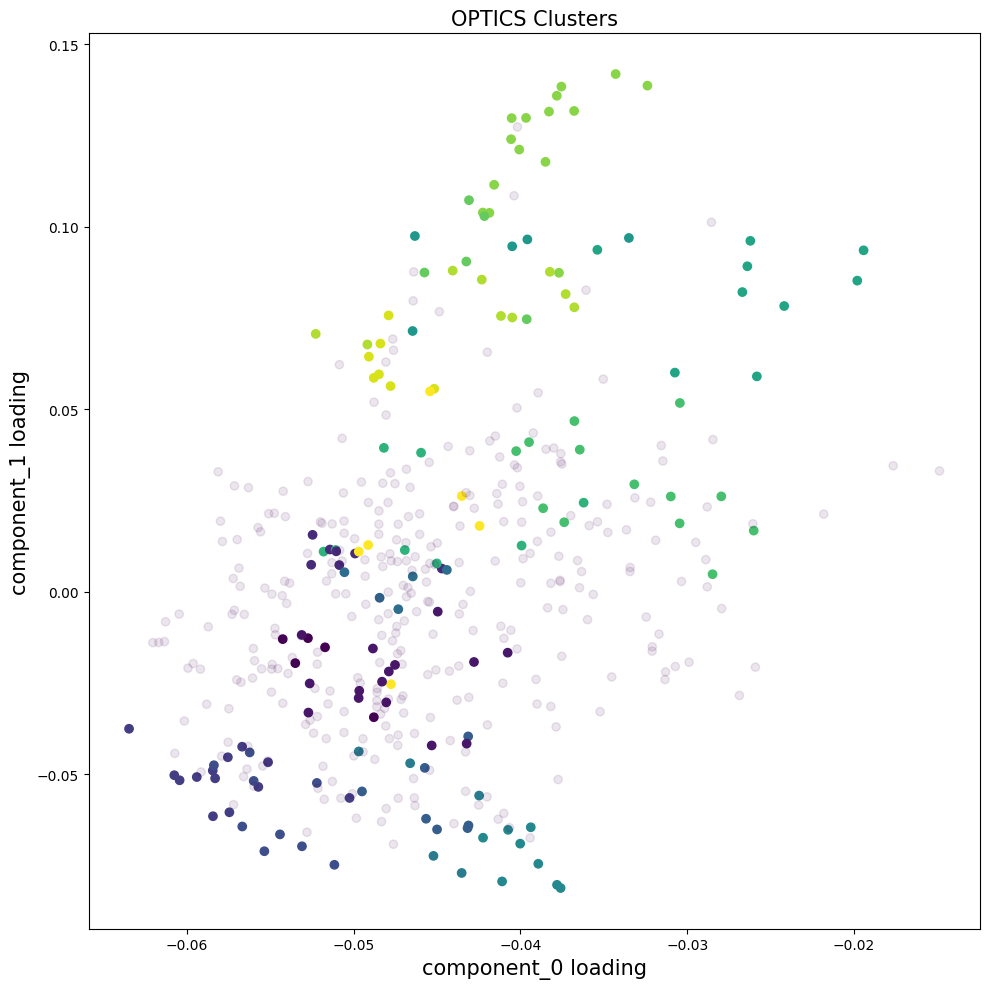

In [126]:
op.plot_clusters(n_dimensions=2)


## State 3: Select Pairs
### Apply Critera

Sarmento and Horta suggest four criteria to further filter the potential pairs to increase the probability of selecting pairs of securities whose prices will continue to mean revert in the future.
* Statistically significant t-stat from the Engle-Granger test (5% level)
* Hurst exponent < 0.5  
* Half-life between [1, 252]   
* Spread must cross the mean on average 12x per year  

These four criteria indicate positive characteristics for potential pairs of securities. The Engle-Granger tests the pair for cointegration. A Hurst exponent below 0.5 indicates that the pair of prices regresses strongly to the mean. Pairs with extreme half-life values, below 1 or above 252, are excluded from the selected pairs. Extreme half-life values indicate a price series that either reverts too quickly or too slowly to be traded. Finally, the price series must cross the long-term spread mean on average 12 times a year. This enforces one trade on average, per month.

After filtering potential pairs, I found 8 pairs of securities that meet all four criteria. We plot the prices individual prices series and the beta-adjusted spread for each pair below.


### Engle-Granger Test

If $x_t$ and $y_t$ are non-stationary and order of integration d=1, then a linear combination of them must be stationary for some value of $\beta$ and $\mu_t$.   
<br>
<center> $y_t - \beta x_t = \mu_t$ ; where $\mu_t$ is stationary. </center>

### Hurst Exponent Calculation
The Hurst exponent, H, is used to measure the long-term memory of a time series. A value in the range of [0-0.5) indicates that a time series reverts strongly to the mean while a value of [0.5-1] indicates a time series with long-term positive autocorrelation and is likely to diverge. The Hurst exponent is calculated as:

<br>
<center> $\begin{aligned} \mathbb{E}\big[\frac{R(n)}{S(n)}\big] = Cn^H , n \rightarrow \infty\end{aligned}$</center>
$R(n)$ is the range of the first $n$ cumulative deviations from the mean.  
$S(n)$ is the series of the first $n$ standard deviations.  
$\mathbb{E}$ is the expected value.  
$n$ is the number of observations in the time series.  
$C$ is a constant.  

### Half-life Calculation

The half-life of a series is the amount of time it takes for a series to return to half its initial value and is defined as:

<br>
<center> $\begin{aligned} N(t) = N_0e^{-\lambda t} \end{aligned}$</center>
$N_0$ is the initial quantity of the spread that will decay.  
$N(t)$ is the quantity that still remains and has not yet decayed after a time $t$.  
$\lambda$ is a positive number called the decay constant.  

The half-life, $t_{1/2}$ is defined as:
<center> $\begin{aligned} t_{1/2} = \frac{ln(2)}{\lambda} \end{aligned}$</center>


Spreads with short half-lives indicate portfolios that revert to the mean often and create many trading opportunities.

### Calculate potential pair statistics

In [127]:
op.calc_eg_norm_spreads()
op.calc_hurst_exponents()
op.calc_half_lives()
op.calc_avg_cross_count()

### Filter potential pairs

In [152]:
op.filter_pairs()
op.filtered_pairs

Found 6 tradable pairs!


,pair,pvalue,hurst_exp,half_life,avg_cross_count
197,"(MET, RJF)",0.004845,0.384411,48.251101,14.725360
225,"(FITB, PNC)",0.010437,0.359230,58.141337,12.761979
326,"(MDLZ, PEP)",0.042599,0.421668,60.862905,13.350993
385,"(DHR, TMO)",0.006851,0.453941,48.827747,16.983249
481,"(LNT, AEE)",0.012319,0.388371,40.398097,16.001558
585,"(WEC, XEL)",0.006634,0.275796,22.569447,16.099727


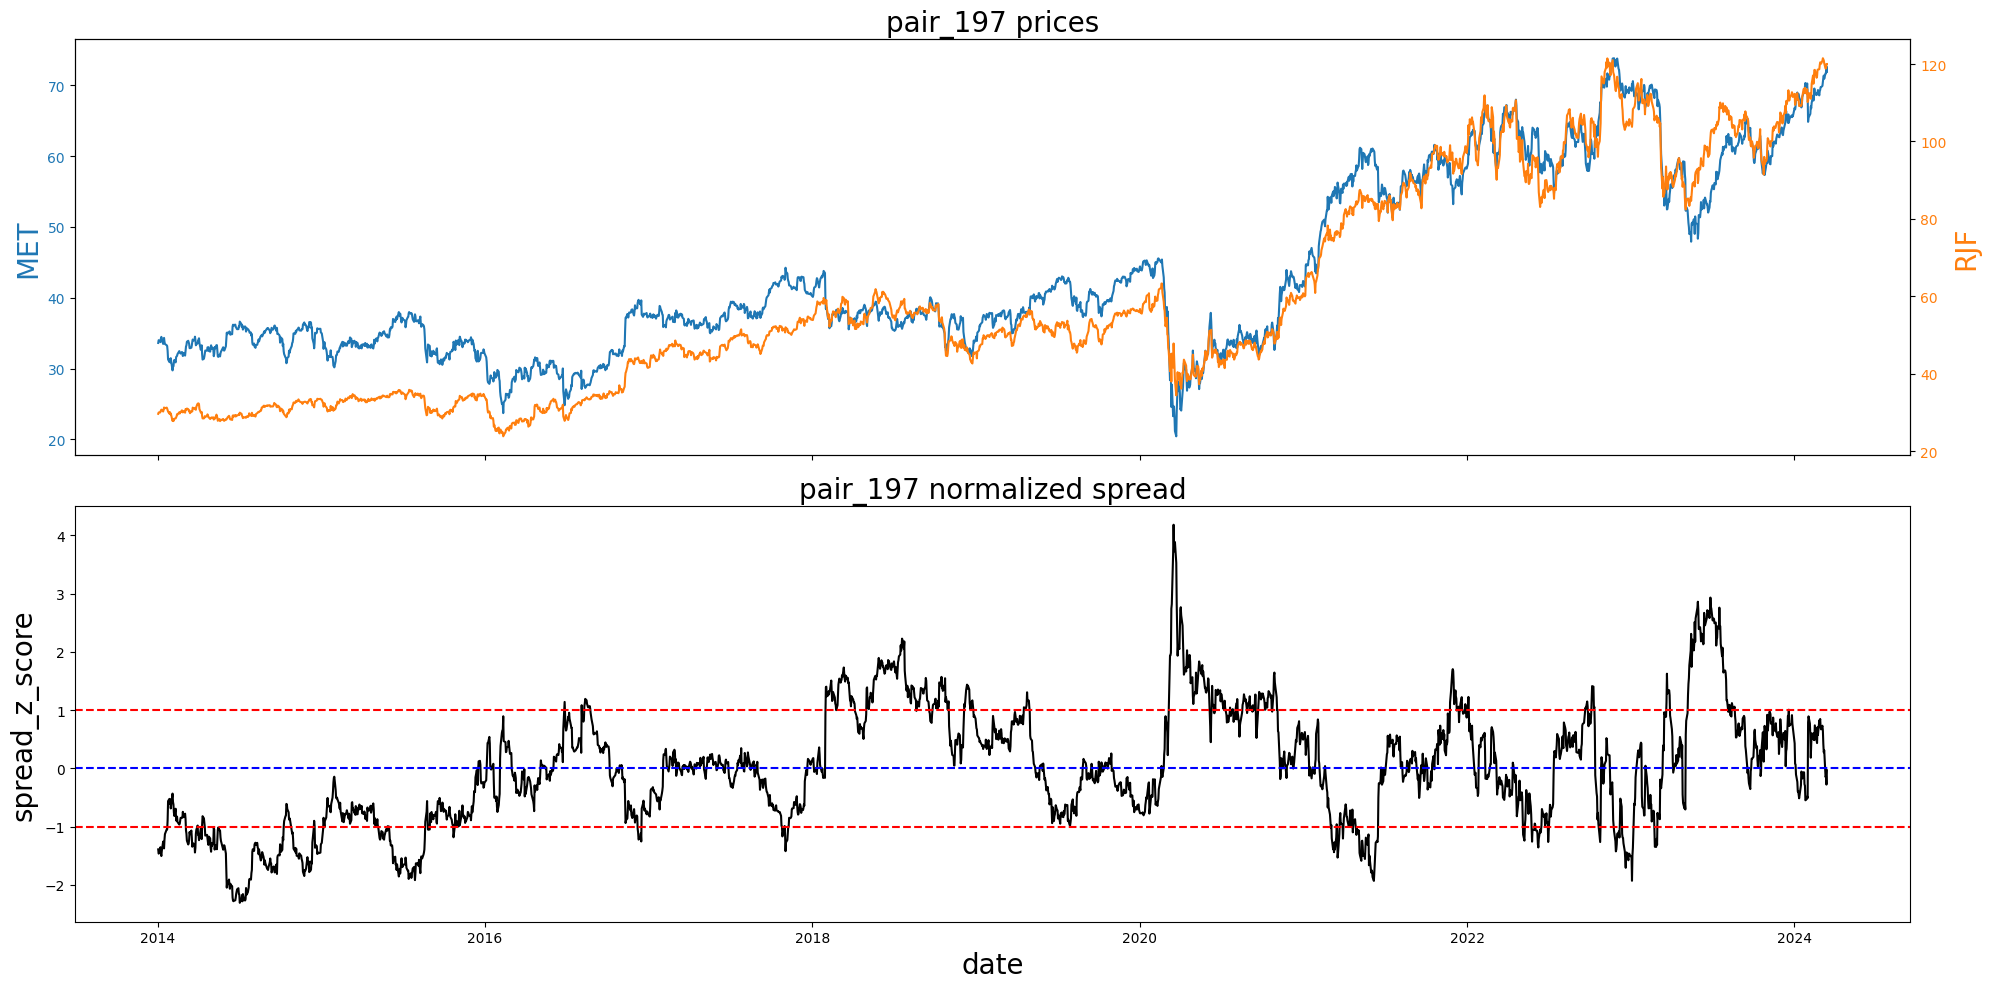

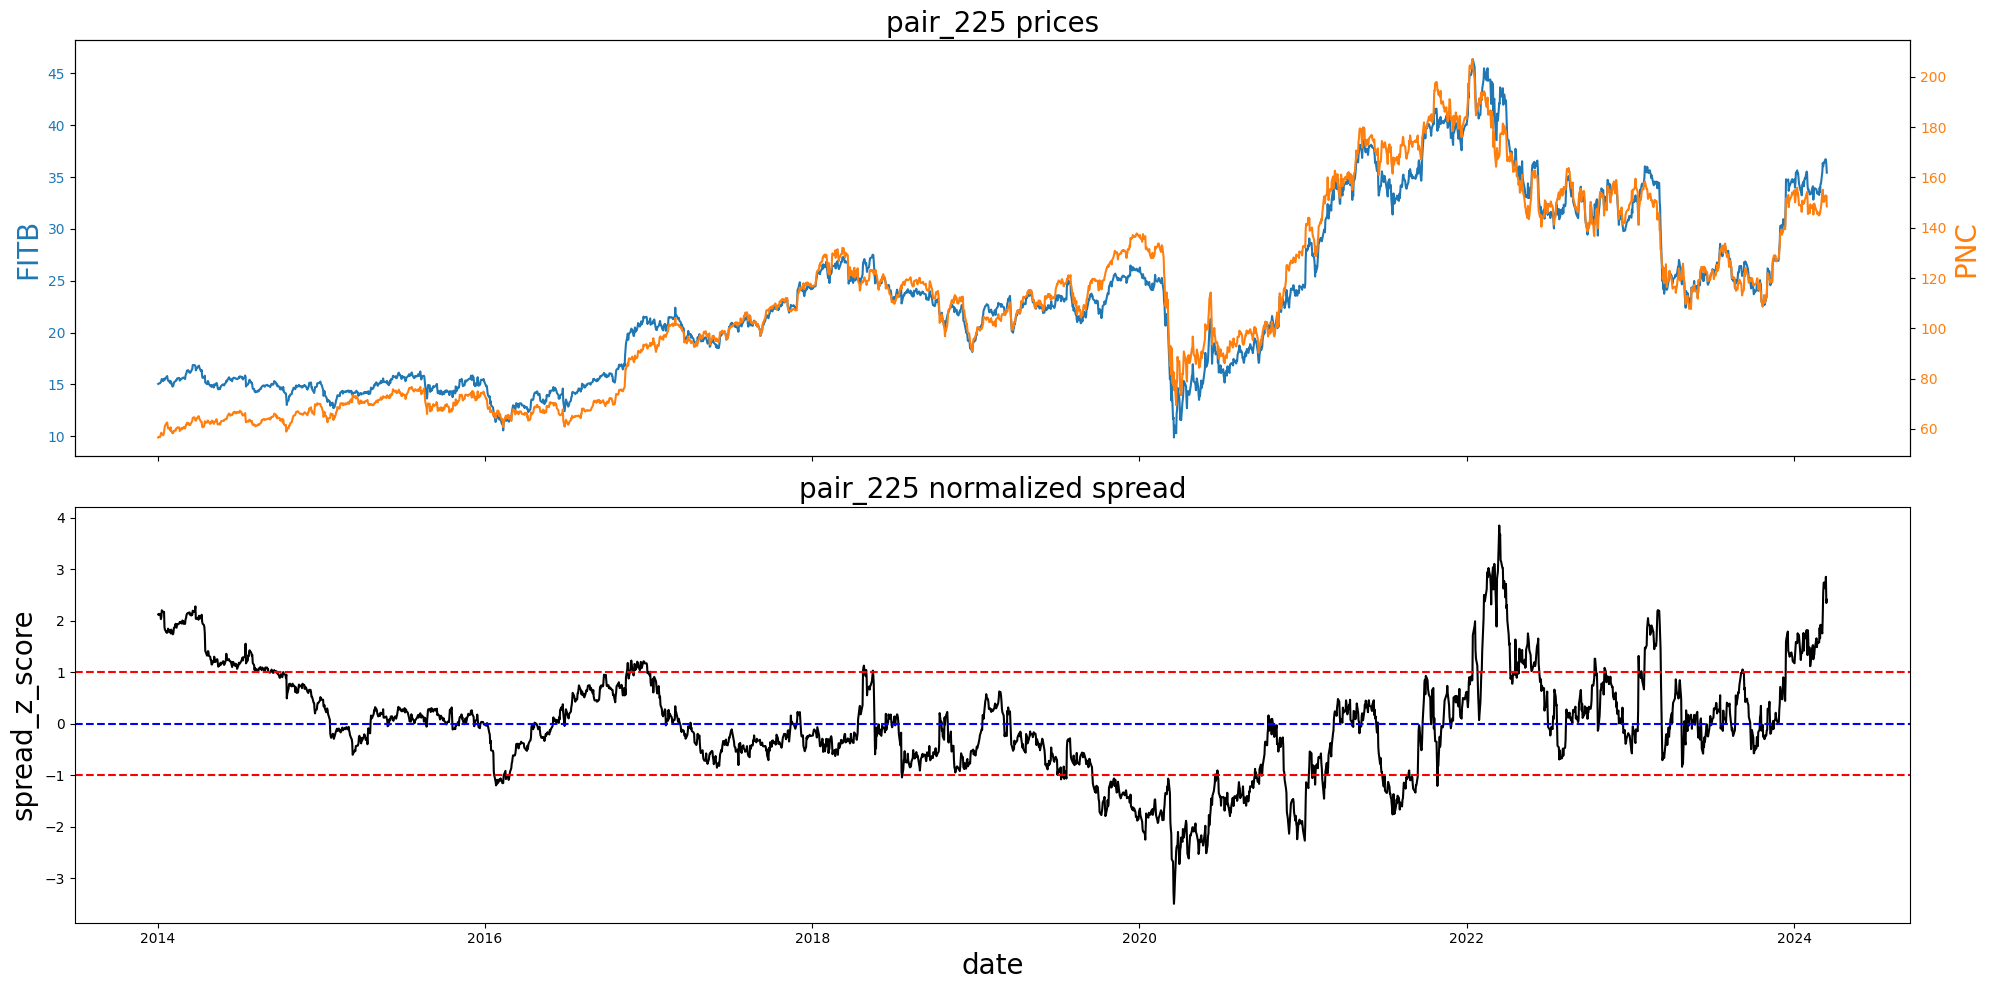

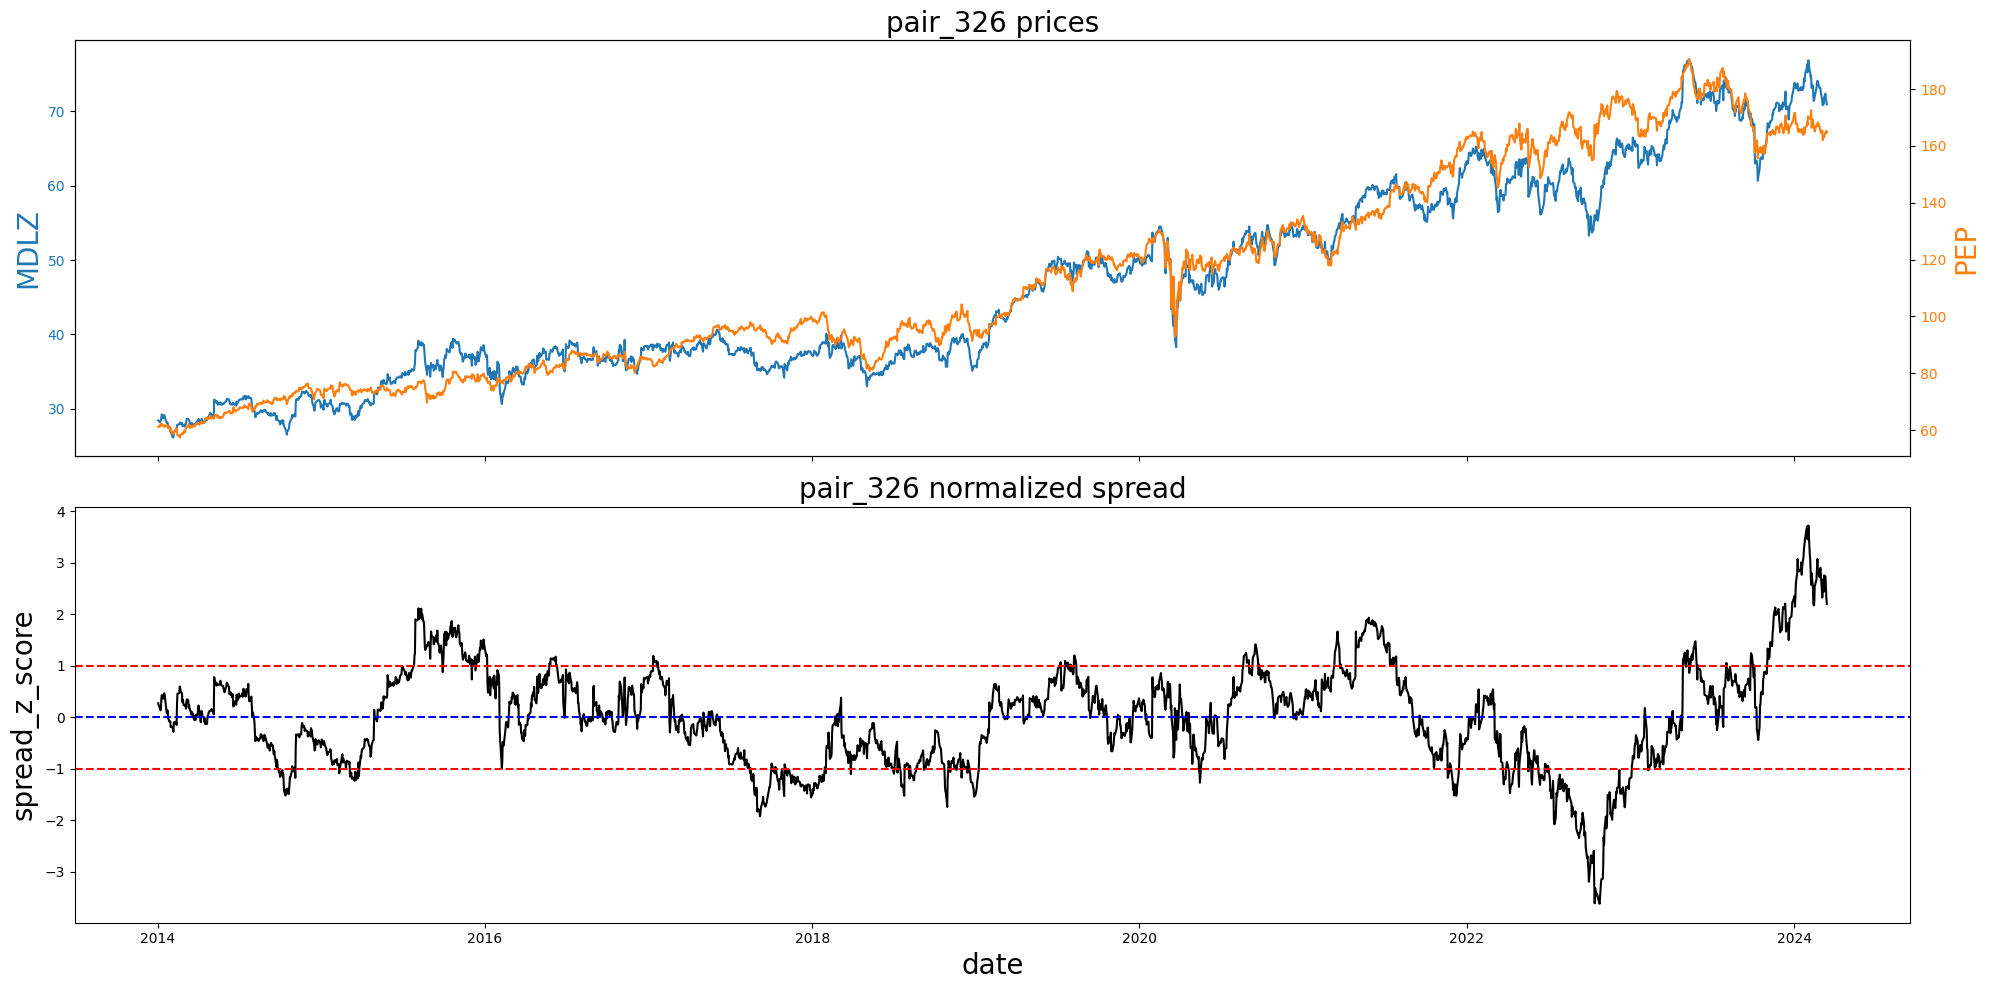

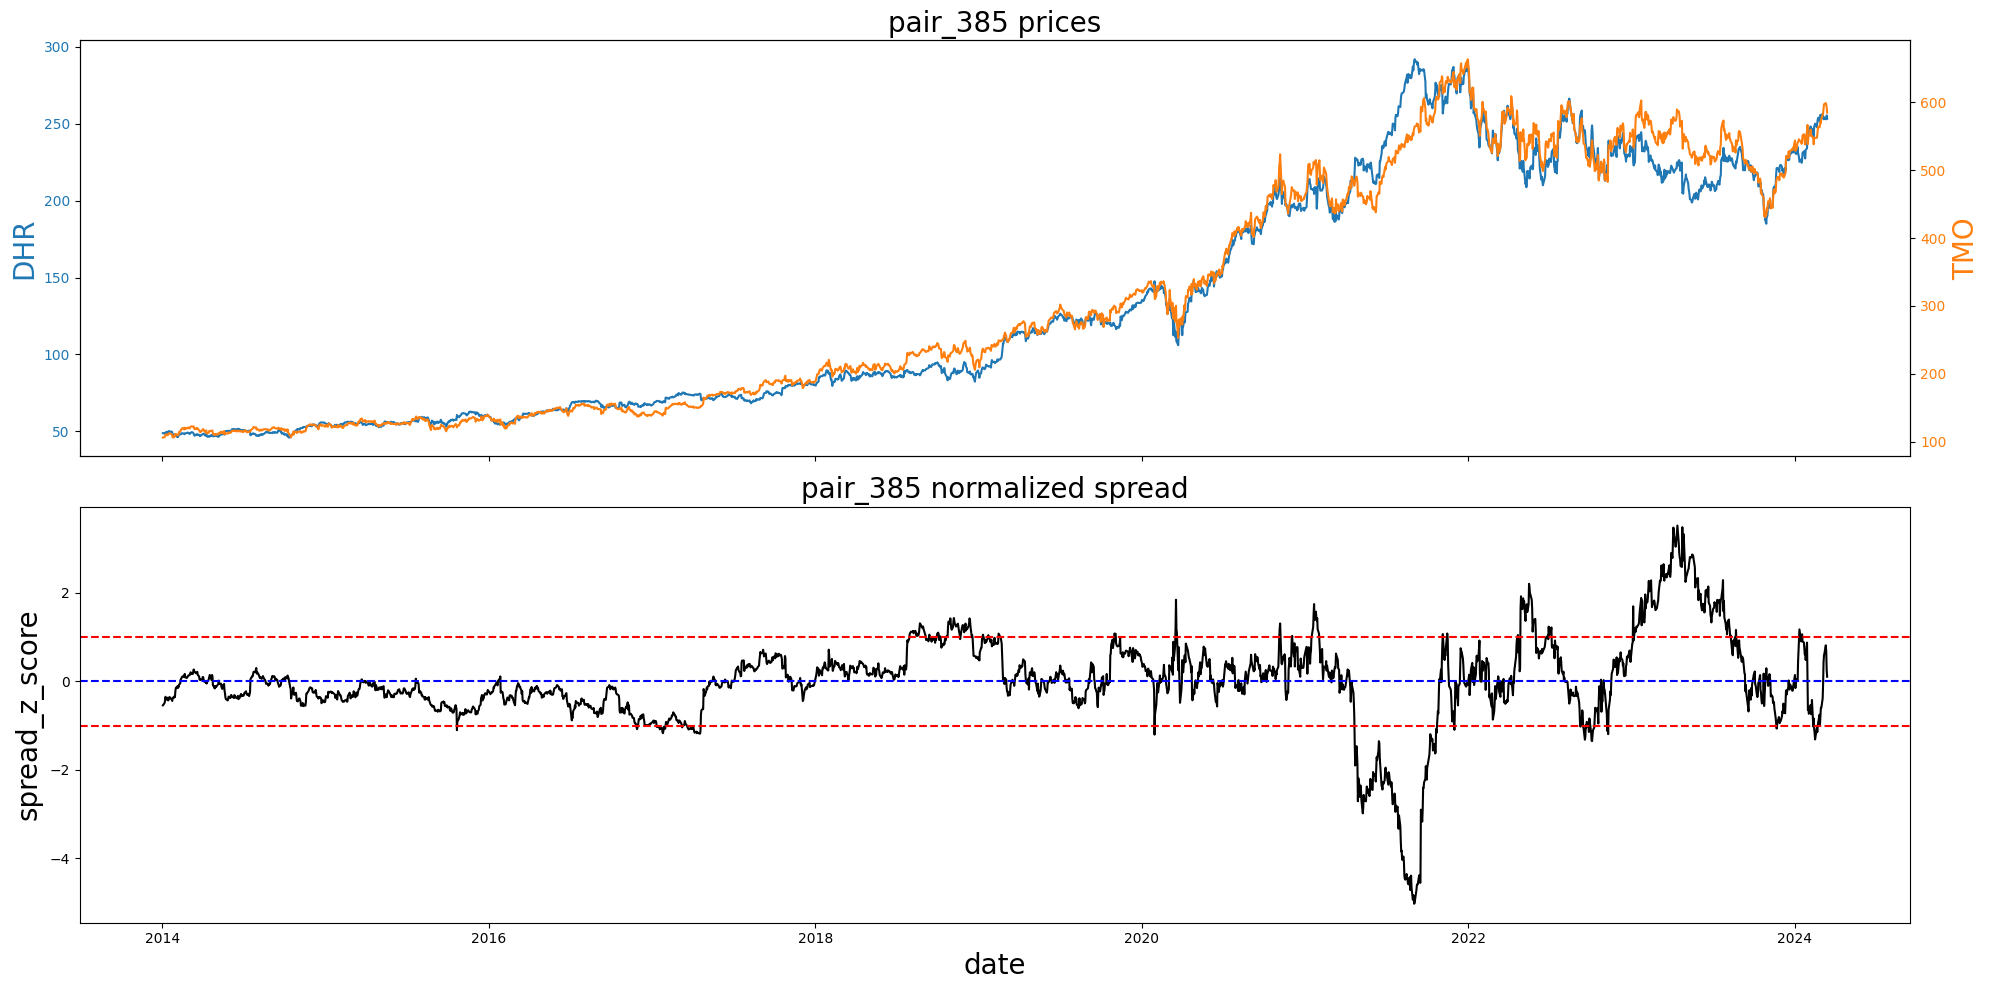

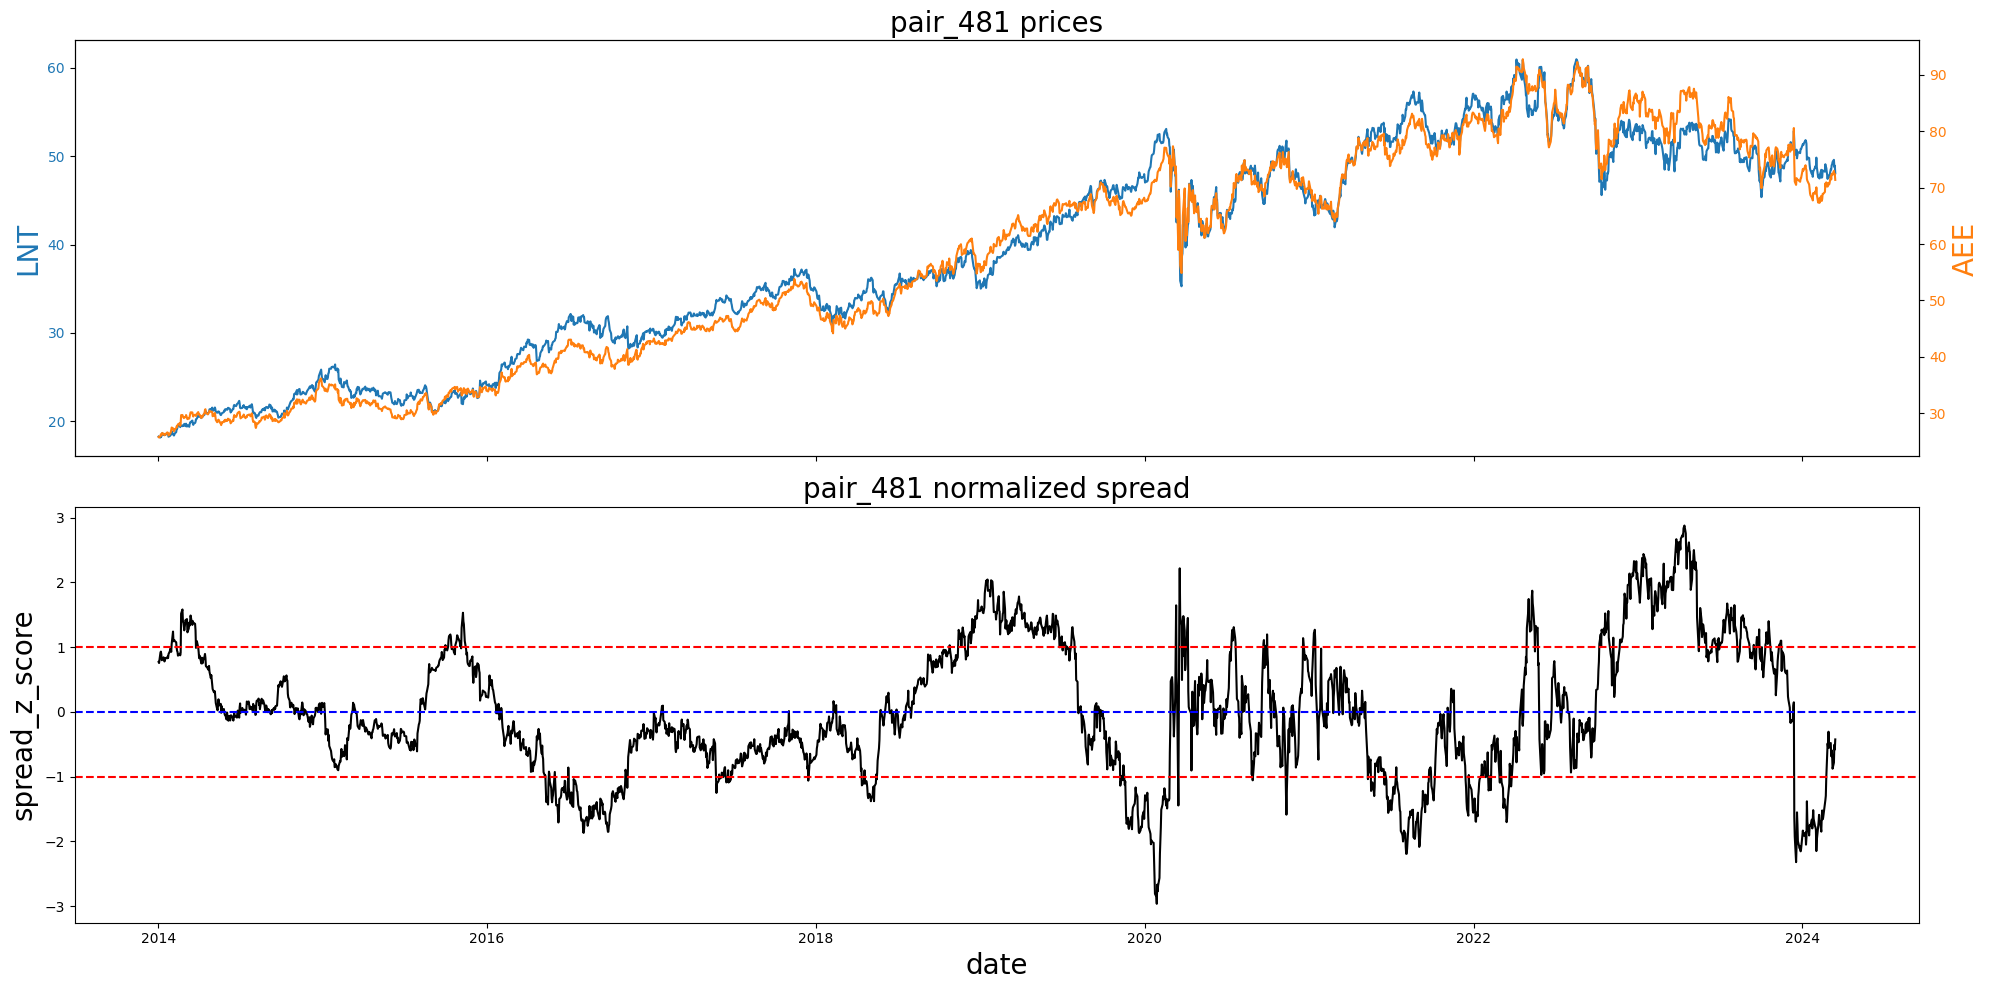

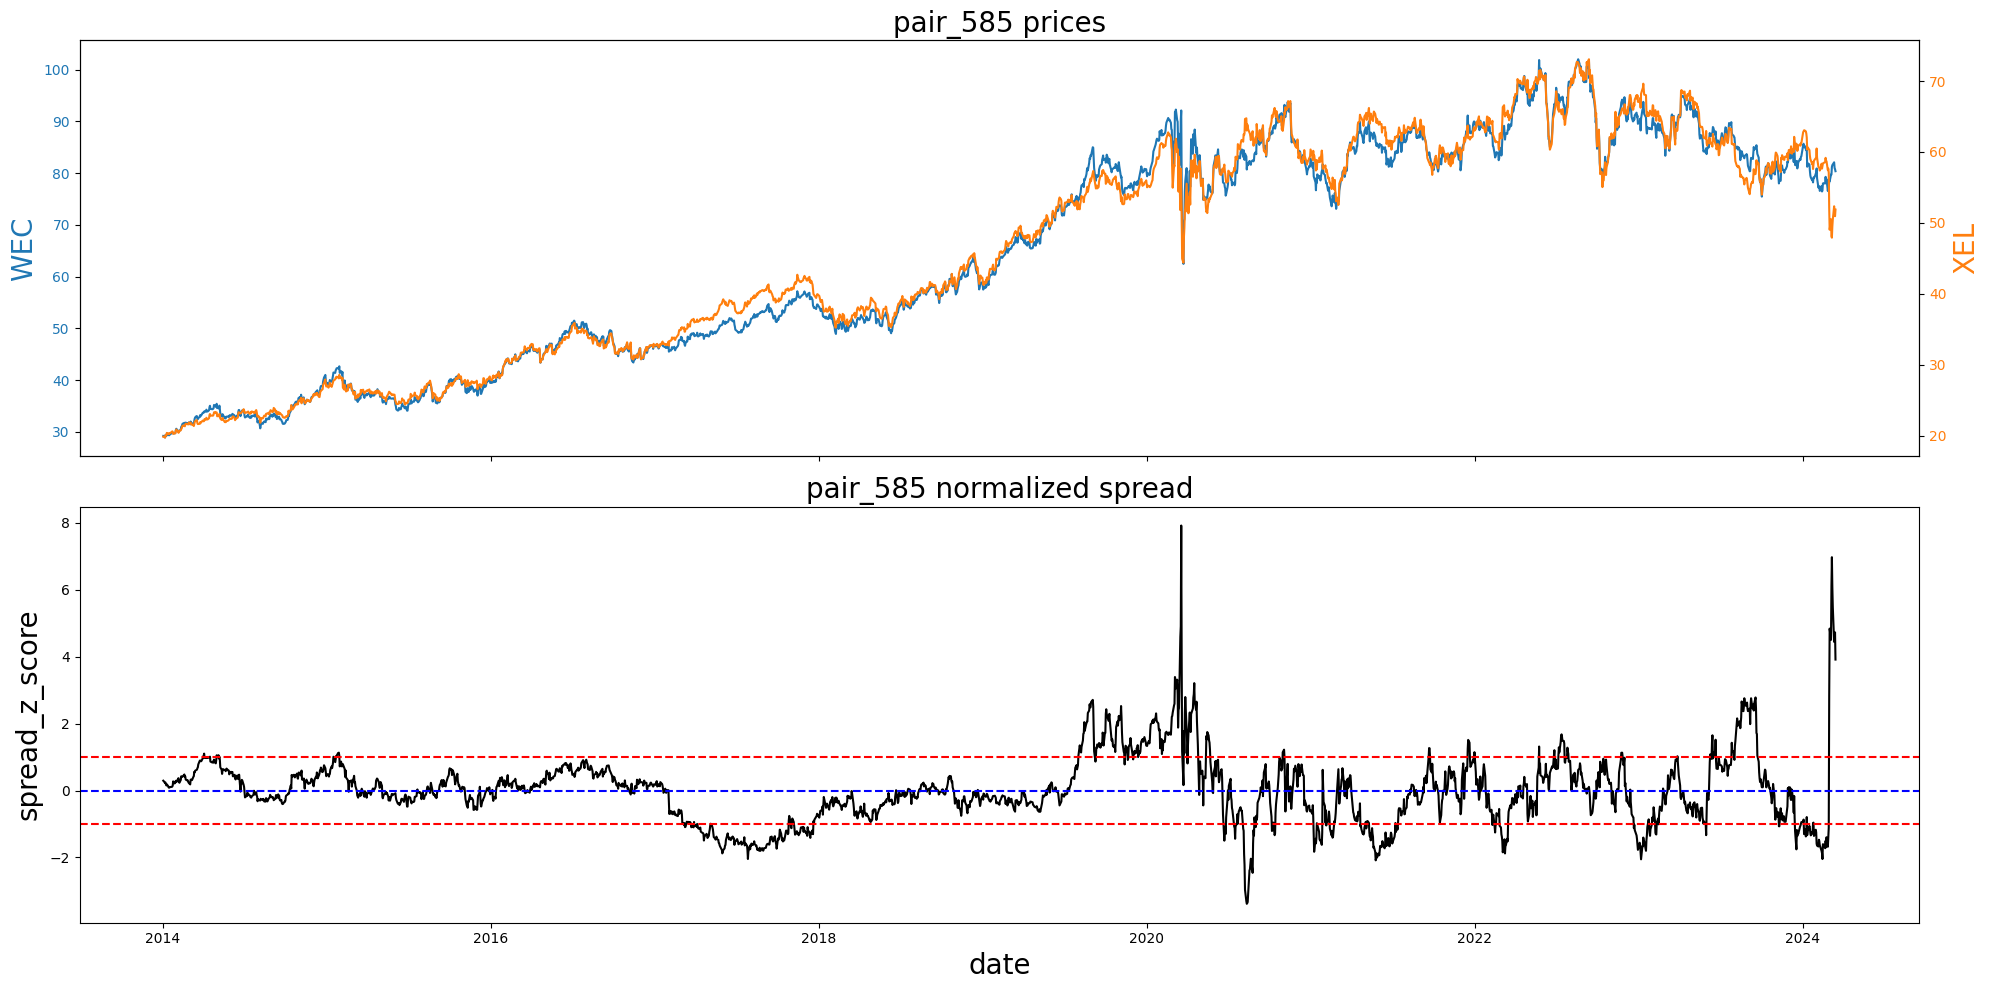

In [151]:
for i in op.filtered_pairs.index:
    op.plot_pair_price_spread(idx=i)

## My notes and further TODO


My doubts:
1. Optic cluster algorithm does not measure the stock sector (IT, energy etc). Some of the pair are from different sectors. Is this even make sense, no idea.
2. PCA can reduce the dimension of the datasets but also maybe we are loosing something. But this is faster to calculate the cluster.
3. Need to do backtesting.
4. I can apply another filter to remove all the stock which price is less than 50 or greater than 200 to have a certain hedge ratio.
5. Consider 10 years of data instead of 2 year would.


New test:
When I download 10 years of data, the model gives quite awesome results. I have found 8 pairs of stock which are really make sense.

## Back testing

In [130]:
pairs = op.pairs[op.filtered_pairs.index[0]]
test_data = op.norm_spreads[0]
A = pairs[0]
B = pairs[1]
securities_A = d[A]
securities_A[1]

34.00527572631836

Total pair

In [153]:
for i in op.filtered_pairs.index:
    se = op.pairs[i]
    print(se)

print(op.filtered_pairs.index[0])

('MET', 'RJF')
('FITB', 'PNC')
('MDLZ', 'PEP')
('DHR', 'TMO')
('LNT', 'AEE')
('WEC', 'XEL')
197


In [150]:
pairs = op.pairs[op.filtered_pairs.index[0]]
test_data = op.norm_spreads[0]
A = pairs[0]
B = pairs[1]
securities_A = d[A]
securities_B = d[B]
df = get_dataset(A)
pnls = []
entry = None
dates = []
unrealized = []
unrealized_dates = []
inpos = 0
hold_times = []
COMMS = 0.005
for i in range(len(df)):
  unr = ((securities_A.iloc[i]-securities_A.iloc[i-1])/securities_A.iloc[i-1])*inpos
  unrealized.append(unr)
  unrealized_dates.append(securities_A.index[i])
  df['Signal'] = 0
  if test_data[i] <= -1:
      #if entry:
        #pnl = (entry - spy.iloc[i])/entry
        #pnls.append(pnl)
        #dates.append(spy.index[i])
        #hold_times.append((spy.index[i]-start).total_seconds())
      if inpos == 0:
        entry = securities_A.iloc[i]
        start = securities_A.index[i]
        unrealized[-1] -= COMMS/2
        df['Signal'] = 1
      entry = securities_A.iloc[i]
      inpos = 1
      start = securities_A.index[i]
      unrealized[-1] -= COMMS/2

  elif test_data[i] >= 1:
      if entry:
        pnl = (securities_A.iloc[i] - entry)/entry - COMMS
        pnls.append(pnl)
        dates.append(securities_A.index[i])
        hold_times.append((securities_A.index[i]-start).total_seconds())
        unrealized[-1] -= COMMS/2
        df['Signal'] = -1
      entry = securities_A.iloc[i]
      inpos = 0
      start = securities_A.index[i]

In [149]:
print(df['Signal'])

Date
2014-01-02 00:00:00-05:00    0
2014-01-03 00:00:00-05:00    0
2014-01-06 00:00:00-05:00    0
2014-01-07 00:00:00-05:00    0
2014-01-08 00:00:00-05:00    0
                            ..
2024-03-08 00:00:00-05:00    0
2024-03-11 00:00:00-04:00    0
2024-03-12 00:00:00-04:00    0
2024-03-13 00:00:00-04:00    0
2024-03-14 00:00:00-04:00    0
Name: Signal, Length: 2567, dtype: int64


In [147]:
print(len(pnls))
print(len(dates))

286
286


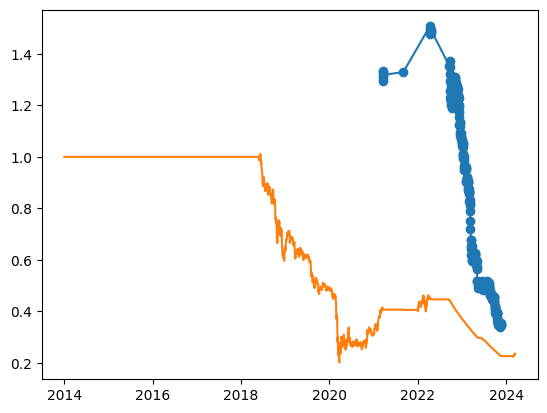

In [148]:
plt.plot(dates, np.cumprod(1+np.array(pnls)),'-o')
plt.plot(unrealized_dates,np.cumprod(1+np.array(unrealized)))

In [136]:
# sharpe ratio
rar = np.mean(unrealized)/np.std(unrealized)*np.sqrt(252)
rar

0.3536037812164082

### total holding times

In [137]:
hold_days = np.array(hold_times)/86400
np.mean(hold_days)

560.0

In [138]:
df_rets = pd.DataFrame(unrealized, index=unrealized_dates)
df_pnl = (1+df_rets).cumprod()

<Axes: >

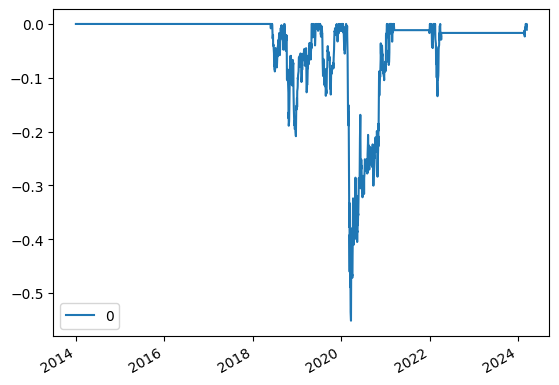

In [139]:
(df_pnl/df_pnl.expanding().max()-1).plot()

In [140]:
beta = np.corrcoef(securities_A.pct_change().iloc[2:],df_rets[0].iloc[2:])[0,1]
beta

0.7168026568537799

# backtesting using python lib

In [141]:
!pip install backtesting

from backtesting import Backtest, Strategy


In [142]:
class PairTrading(Strategy):
    def init(self):
        price = 10
        inpos = 0
    def next(self):
        test_data = op.norm_spreads[0]
        for i in range(len(df)):
          if test_data[i] <= -1:
                self.buy()

          elif test_data[i] >= 0:
                self.sell()


bt = Backtest(df, PairTrading)
stats = bt.run()
bt.plot()


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1639', ...)